In [ ]:
!pip install pymcubes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import torch
from tqdm import tqdm
from mcubes import marching_cubes

from nerf import render_rays, DEVICE, load_model


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


## vertex lookups

In [13]:
cube_corners = np.array([
[0, 0, 0],
[1, 0, 0],
[1, 1, 0],
[0, 1, 0],
[0, 0, 1],
[1, 0, 1],
[1, 1, 1],
[0, 1, 1]
])

cube_edges = np.array([
[0, 1],
[1, 2],
[2, 3],
[3, 0],
[4, 5],
[5, 6],
[6, 7],
[7, 4],
[0, 4],
[1, 5],
[2, 6],
[3, 7]
])

# http://paulbourke.net/geometry/polygonise/
cube_configs = np.array([
    [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 8, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 1, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [1, 8, 3, 9, 8, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [1, 2, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 8, 3, 1, 2, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [9, 2, 10, 0, 2, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [2, 8, 3, 2, 10, 8, 10, 9, 8, -1, -1, -1, -1, -1, -1, -1],
    [3, 11, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 11, 2, 8, 11, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [1, 9, 0, 2, 3, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [1, 11, 2, 1, 9, 11, 9, 8, 11, -1, -1, -1, -1, -1, -1, -1],
    [3, 10, 1, 11, 10, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 10, 1, 0, 8, 10, 8, 11, 10, -1, -1, -1, -1, -1, -1, -1],
    [3, 9, 0, 3, 11, 9, 11, 10, 9, -1, -1, -1, -1, -1, -1, -1],
    [9, 8, 10, 10, 8, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [4, 7, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [4, 3, 0, 7, 3, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 1, 9, 8, 4, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [4, 1, 9, 4, 7, 1, 7, 3, 1, -1, -1, -1, -1, -1, -1, -1],
    [1, 2, 10, 8, 4, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [3, 4, 7, 3, 0, 4, 1, 2, 10, -1, -1, -1, -1, -1, -1, -1],
    [9, 2, 10, 9, 0, 2, 8, 4, 7, -1, -1, -1, -1, -1, -1, -1],
    [2, 10, 9, 2, 9, 7, 2, 7, 3, 7, 9, 4, -1, -1, -1, -1],
    [8, 4, 7, 3, 11, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [11, 4, 7, 11, 2, 4, 2, 0, 4, -1, -1, -1, -1, -1, -1, -1],
    [9, 0, 1, 8, 4, 7, 2, 3, 11, -1, -1, -1, -1, -1, -1, -1],
    [4, 7, 11, 9, 4, 11, 9, 11, 2, 9, 2, 1, -1, -1, -1, -1],
    [3, 10, 1, 3, 11, 10, 7, 8, 4, -1, -1, -1, -1, -1, -1, -1],
    [1, 11, 10, 1, 4, 11, 1, 0, 4, 7, 11, 4, -1, -1, -1, -1],
    [4, 7, 8, 9, 0, 11, 9, 11, 10, 11, 0, 3, -1, -1, -1, -1],
    [4, 7, 11, 4, 11, 9, 9, 11, 10, -1, -1, -1, -1, -1, -1, -1],
    [9, 5, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [9, 5, 4, 0, 8, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 5, 4, 1, 5, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [8, 5, 4, 8, 3, 5, 3, 1, 5, -1, -1, -1, -1, -1, -1, -1],
    [1, 2, 10, 9, 5, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [3, 0, 8, 1, 2, 10, 4, 9, 5, -1, -1, -1, -1, -1, -1, -1],
    [5, 2, 10, 5, 4, 2, 4, 0, 2, -1, -1, -1, -1, -1, -1, -1],
    [2, 10, 5, 3, 2, 5, 3, 5, 4, 3, 4, 8, -1, -1, -1, -1],
    [9, 5, 4, 2, 3, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 11, 2, 0, 8, 11, 4, 9, 5, -1, -1, -1, -1, -1, -1, -1],
    [0, 5, 4, 0, 1, 5, 2, 3, 11, -1, -1, -1, -1, -1, -1, -1],
    [2, 1, 5, 2, 5, 8, 2, 8, 11, 4, 8, 5, -1, -1, -1, -1],
    [10, 3, 11, 10, 1, 3, 9, 5, 4, -1, -1, -1, -1, -1, -1, -1],
    [4, 9, 5, 0, 8, 1, 8, 10, 1, 8, 11, 10, -1, -1, -1, -1],
    [5, 4, 0, 5, 0, 11, 5, 11, 10, 11, 0, 3, -1, -1, -1, -1],
    [5, 4, 8, 5, 8, 10, 10, 8, 11, -1, -1, -1, -1, -1, -1, -1],
    [9, 7, 8, 5, 7, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [9, 3, 0, 9, 5, 3, 5, 7, 3, -1, -1, -1, -1, -1, -1, -1],
    [0, 7, 8, 0, 1, 7, 1, 5, 7, -1, -1, -1, -1, -1, -1, -1],
    [1, 5, 3, 3, 5, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [9, 7, 8, 9, 5, 7, 10, 1, 2, -1, -1, -1, -1, -1, -1, -1],
    [10, 1, 2, 9, 5, 0, 5, 3, 0, 5, 7, 3, -1, -1, -1, -1],
    [8, 0, 2, 8, 2, 5, 8, 5, 7, 10, 5, 2, -1, -1, -1, -1],
    [2, 10, 5, 2, 5, 3, 3, 5, 7, -1, -1, -1, -1, -1, -1, -1],
    [7, 9, 5, 7, 8, 9, 3, 11, 2, -1, -1, -1, -1, -1, -1, -1],
    [9, 5, 7, 9, 7, 2, 9, 2, 0, 2, 7, 11, -1, -1, -1, -1],
    [2, 3, 11, 0, 1, 8, 1, 7, 8, 1, 5, 7, -1, -1, -1, -1],
    [11, 2, 1, 11, 1, 7, 7, 1, 5, -1, -1, -1, -1, -1, -1, -1],
    [9, 5, 8, 8, 5, 7, 10, 1, 3, 10, 3, 11, -1, -1, -1, -1],
    [5, 7, 0, 5, 0, 9, 7, 11, 0, 1, 0, 10, 11, 10, 0, -1],
    [11, 10, 0, 11, 0, 3, 10, 5, 0, 8, 0, 7, 5, 7, 0, -1],
    [11, 10, 5, 7, 11, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [10, 6, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 8, 3, 5, 10, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [9, 0, 1, 5, 10, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [1, 8, 3, 1, 9, 8, 5, 10, 6, -1, -1, -1, -1, -1, -1, -1],
    [1, 6, 5, 2, 6, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [1, 6, 5, 1, 2, 6, 3, 0, 8, -1, -1, -1, -1, -1, -1, -1],
    [9, 6, 5, 9, 0, 6, 0, 2, 6, -1, -1, -1, -1, -1, -1, -1],
    [5, 9, 8, 5, 8, 2, 5, 2, 6, 3, 2, 8, -1, -1, -1, -1],
    [2, 3, 11, 10, 6, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [11, 0, 8, 11, 2, 0, 10, 6, 5, -1, -1, -1, -1, -1, -1, -1],
    [0, 1, 9, 2, 3, 11, 5, 10, 6, -1, -1, -1, -1, -1, -1, -1],
    [5, 10, 6, 1, 9, 2, 9, 11, 2, 9, 8, 11, -1, -1, -1, -1],
    [6, 3, 11, 6, 5, 3, 5, 1, 3, -1, -1, -1, -1, -1, -1, -1],
    [0, 8, 11, 0, 11, 5, 0, 5, 1, 5, 11, 6, -1, -1, -1, -1],
    [3, 11, 6, 0, 3, 6, 0, 6, 5, 0, 5, 9, -1, -1, -1, -1],
    [6, 5, 9, 6, 9, 11, 11, 9, 8, -1, -1, -1, -1, -1, -1, -1],
    [5, 10, 6, 4, 7, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [4, 3, 0, 4, 7, 3, 6, 5, 10, -1, -1, -1, -1, -1, -1, -1],
    [1, 9, 0, 5, 10, 6, 8, 4, 7, -1, -1, -1, -1, -1, -1, -1],
    [10, 6, 5, 1, 9, 7, 1, 7, 3, 7, 9, 4, -1, -1, -1, -1],
    [6, 1, 2, 6, 5, 1, 4, 7, 8, -1, -1, -1, -1, -1, -1, -1],
    [1, 2, 5, 5, 2, 6, 3, 0, 4, 3, 4, 7, -1, -1, -1, -1],
    [8, 4, 7, 9, 0, 5, 0, 6, 5, 0, 2, 6, -1, -1, -1, -1],
    [7, 3, 9, 7, 9, 4, 3, 2, 9, 5, 9, 6, 2, 6, 9, -1],
    [3, 11, 2, 7, 8, 4, 10, 6, 5, -1, -1, -1, -1, -1, -1, -1],
    [5, 10, 6, 4, 7, 2, 4, 2, 0, 2, 7, 11, -1, -1, -1, -1],
    [0, 1, 9, 4, 7, 8, 2, 3, 11, 5, 10, 6, -1, -1, -1, -1],
    [9, 2, 1, 9, 11, 2, 9, 4, 11, 7, 11, 4, 5, 10, 6, -1],
    [8, 4, 7, 3, 11, 5, 3, 5, 1, 5, 11, 6, -1, -1, -1, -1],
    [5, 1, 11, 5, 11, 6, 1, 0, 11, 7, 11, 4, 0, 4, 11, -1],
    [0, 5, 9, 0, 6, 5, 0, 3, 6, 11, 6, 3, 8, 4, 7, -1],
    [6, 5, 9, 6, 9, 11, 4, 7, 9, 7, 11, 9, -1, -1, -1, -1],
    [10, 4, 9, 6, 4, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [4, 10, 6, 4, 9, 10, 0, 8, 3, -1, -1, -1, -1, -1, -1, -1],
    [10, 0, 1, 10, 6, 0, 6, 4, 0, -1, -1, -1, -1, -1, -1, -1],
    [8, 3, 1, 8, 1, 6, 8, 6, 4, 6, 1, 10, -1, -1, -1, -1],
    [1, 4, 9, 1, 2, 4, 2, 6, 4, -1, -1, -1, -1, -1, -1, -1],
    [3, 0, 8, 1, 2, 9, 2, 4, 9, 2, 6, 4, -1, -1, -1, -1],
    [0, 2, 4, 4, 2, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [8, 3, 2, 8, 2, 4, 4, 2, 6, -1, -1, -1, -1, -1, -1, -1],
    [10, 4, 9, 10, 6, 4, 11, 2, 3, -1, -1, -1, -1, -1, -1, -1],
    [0, 8, 2, 2, 8, 11, 4, 9, 10, 4, 10, 6, -1, -1, -1, -1],
    [3, 11, 2, 0, 1, 6, 0, 6, 4, 6, 1, 10, -1, -1, -1, -1],
    [6, 4, 1, 6, 1, 10, 4, 8, 1, 2, 1, 11, 8, 11, 1, -1],
    [9, 6, 4, 9, 3, 6, 9, 1, 3, 11, 6, 3, -1, -1, -1, -1],
    [8, 11, 1, 8, 1, 0, 11, 6, 1, 9, 1, 4, 6, 4, 1, -1],
    [3, 11, 6, 3, 6, 0, 0, 6, 4, -1, -1, -1, -1, -1, -1, -1],
    [6, 4, 8, 11, 6, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [7, 10, 6, 7, 8, 10, 8, 9, 10, -1, -1, -1, -1, -1, -1, -1],
    [0, 7, 3, 0, 10, 7, 0, 9, 10, 6, 7, 10, -1, -1, -1, -1],
    [10, 6, 7, 1, 10, 7, 1, 7, 8, 1, 8, 0, -1, -1, -1, -1],
    [10, 6, 7, 10, 7, 1, 1, 7, 3, -1, -1, -1, -1, -1, -1, -1],
    [1, 2, 6, 1, 6, 8, 1, 8, 9, 8, 6, 7, -1, -1, -1, -1],
    [2, 6, 9, 2, 9, 1, 6, 7, 9, 0, 9, 3, 7, 3, 9, -1],
    [7, 8, 0, 7, 0, 6, 6, 0, 2, -1, -1, -1, -1, -1, -1, -1],
    [7, 3, 2, 6, 7, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [2, 3, 11, 10, 6, 8, 10, 8, 9, 8, 6, 7, -1, -1, -1, -1],
    [2, 0, 7, 2, 7, 11, 0, 9, 7, 6, 7, 10, 9, 10, 7, -1],
    [1, 8, 0, 1, 7, 8, 1, 10, 7, 6, 7, 10, 2, 3, 11, -1],
    [11, 2, 1, 11, 1, 7, 10, 6, 1, 6, 7, 1, -1, -1, -1, -1],
    [8, 9, 6, 8, 6, 7, 9, 1, 6, 11, 6, 3, 1, 3, 6, -1],
    [0, 9, 1, 11, 6, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [7, 8, 0, 7, 0, 6, 3, 11, 0, 11, 6, 0, -1, -1, -1, -1],
    [7, 11, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [7, 6, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [3, 0, 8, 11, 7, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 1, 9, 11, 7, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [8, 1, 9, 8, 3, 1, 11, 7, 6, -1, -1, -1, -1, -1, -1, -1],
    [10, 1, 2, 6, 11, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [1, 2, 10, 3, 0, 8, 6, 11, 7, -1, -1, -1, -1, -1, -1, -1],
    [2, 9, 0, 2, 10, 9, 6, 11, 7, -1, -1, -1, -1, -1, -1, -1],
    [6, 11, 7, 2, 10, 3, 10, 8, 3, 10, 9, 8, -1, -1, -1, -1],
    [7, 2, 3, 6, 2, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [7, 0, 8, 7, 6, 0, 6, 2, 0, -1, -1, -1, -1, -1, -1, -1],
    [2, 7, 6, 2, 3, 7, 0, 1, 9, -1, -1, -1, -1, -1, -1, -1],
    [1, 6, 2, 1, 8, 6, 1, 9, 8, 8, 7, 6, -1, -1, -1, -1],
    [10, 7, 6, 10, 1, 7, 1, 3, 7, -1, -1, -1, -1, -1, -1, -1],
    [10, 7, 6, 1, 7, 10, 1, 8, 7, 1, 0, 8, -1, -1, -1, -1],
    [0, 3, 7, 0, 7, 10, 0, 10, 9, 6, 10, 7, -1, -1, -1, -1],
    [7, 6, 10, 7, 10, 8, 8, 10, 9, -1, -1, -1, -1, -1, -1, -1],
    [6, 8, 4, 11, 8, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [3, 6, 11, 3, 0, 6, 0, 4, 6, -1, -1, -1, -1, -1, -1, -1],
    [8, 6, 11, 8, 4, 6, 9, 0, 1, -1, -1, -1, -1, -1, -1, -1],
    [9, 4, 6, 9, 6, 3, 9, 3, 1, 11, 3, 6, -1, -1, -1, -1],
    [6, 8, 4, 6, 11, 8, 2, 10, 1, -1, -1, -1, -1, -1, -1, -1],
    [1, 2, 10, 3, 0, 11, 0, 6, 11, 0, 4, 6, -1, -1, -1, -1],
    [4, 11, 8, 4, 6, 11, 0, 2, 9, 2, 10, 9, -1, -1, -1, -1],
    [10, 9, 3, 10, 3, 2, 9, 4, 3, 11, 3, 6, 4, 6, 3, -1],
    [8, 2, 3, 8, 4, 2, 4, 6, 2, -1, -1, -1, -1, -1, -1, -1],
    [0, 4, 2, 4, 6, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [1, 9, 0, 2, 3, 4, 2, 4, 6, 4, 3, 8, -1, -1, -1, -1],
    [1, 9, 4, 1, 4, 2, 2, 4, 6, -1, -1, -1, -1, -1, -1, -1],
    [8, 1, 3, 8, 6, 1, 8, 4, 6, 6, 10, 1, -1, -1, -1, -1],
    [10, 1, 0, 10, 0, 6, 6, 0, 4, -1, -1, -1, -1, -1, -1, -1],
    [4, 6, 3, 4, 3, 8, 6, 10, 3, 0, 3, 9, 10, 9, 3, -1],
    [10, 9, 4, 6, 10, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [4, 9, 5, 7, 6, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 8, 3, 4, 9, 5, 11, 7, 6, -1, -1, -1, -1, -1, -1, -1],
    [5, 0, 1, 5, 4, 0, 7, 6, 11, -1, -1, -1, -1, -1, -1, -1],
    [11, 7, 6, 8, 3, 4, 3, 5, 4, 3, 1, 5, -1, -1, -1, -1],
    [9, 5, 4, 10, 1, 2, 7, 6, 11, -1, -1, -1, -1, -1, -1, -1],
    [6, 11, 7, 1, 2, 10, 0, 8, 3, 4, 9, 5, -1, -1, -1, -1],
    [7, 6, 11, 5, 4, 10, 4, 2, 10, 4, 0, 2, -1, -1, -1, -1],
    [3, 4, 8, 3, 5, 4, 3, 2, 5, 10, 5, 2, 11, 7, 6, -1],
    [7, 2, 3, 7, 6, 2, 5, 4, 9, -1, -1, -1, -1, -1, -1, -1],
    [9, 5, 4, 0, 8, 6, 0, 6, 2, 6, 8, 7, -1, -1, -1, -1],
    [3, 6, 2, 3, 7, 6, 1, 5, 0, 5, 4, 0, -1, -1, -1, -1],
    [6, 2, 8, 6, 8, 7, 2, 1, 8, 4, 8, 5, 1, 5, 8, -1],
    [9, 5, 4, 10, 1, 6, 1, 7, 6, 1, 3, 7, -1, -1, -1, -1],
    [1, 6, 10, 1, 7, 6, 1, 0, 7, 8, 7, 0, 9, 5, 4, -1],
    [4, 0, 10, 4, 10, 5, 0, 3, 10, 6, 10, 7, 3, 7, 10, -1],
    [7, 6, 10, 7, 10, 8, 5, 4, 10, 4, 8, 10, -1, -1, -1, -1],
    [6, 9, 5, 6, 11, 9, 11, 8, 9, -1, -1, -1, -1, -1, -1, -1],
    [3, 6, 11, 0, 6, 3, 0, 5, 6, 0, 9, 5, -1, -1, -1, -1],
    [0, 11, 8, 0, 5, 11, 0, 1, 5, 5, 6, 11, -1, -1, -1, -1],
    [6, 11, 3, 6, 3, 5, 5, 3, 1, -1, -1, -1, -1, -1, -1, -1],
    [1, 2, 10, 9, 5, 11, 9, 11, 8, 11, 5, 6, -1, -1, -1, -1],
    [0, 11, 3, 0, 6, 11, 0, 9, 6, 5, 6, 9, 1, 2, 10, -1],
    [11, 8, 5, 11, 5, 6, 8, 0, 5, 10, 5, 2, 0, 2, 5, -1],
    [6, 11, 3, 6, 3, 5, 2, 10, 3, 10, 5, 3, -1, -1, -1, -1],
    [5, 8, 9, 5, 2, 8, 5, 6, 2, 3, 8, 2, -1, -1, -1, -1],
    [9, 5, 6, 9, 6, 0, 0, 6, 2, -1, -1, -1, -1, -1, -1, -1],
    [1, 5, 8, 1, 8, 0, 5, 6, 8, 3, 8, 2, 6, 2, 8, -1],
    [1, 5, 6, 2, 1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [1, 3, 6, 1, 6, 10, 3, 8, 6, 5, 6, 9, 8, 9, 6, -1],
    [10, 1, 0, 10, 0, 6, 9, 5, 0, 5, 6, 0, -1, -1, -1, -1],
    [0, 3, 8, 5, 6, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [10, 5, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [11, 5, 10, 7, 5, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [11, 5, 10, 11, 7, 5, 8, 3, 0, -1, -1, -1, -1, -1, -1, -1],
    [5, 11, 7, 5, 10, 11, 1, 9, 0, -1, -1, -1, -1, -1, -1, -1],
    [10, 7, 5, 10, 11, 7, 9, 8, 1, 8, 3, 1, -1, -1, -1, -1],
    [11, 1, 2, 11, 7, 1, 7, 5, 1, -1, -1, -1, -1, -1, -1, -1],
    [0, 8, 3, 1, 2, 7, 1, 7, 5, 7, 2, 11, -1, -1, -1, -1],
    [9, 7, 5, 9, 2, 7, 9, 0, 2, 2, 11, 7, -1, -1, -1, -1],
    [7, 5, 2, 7, 2, 11, 5, 9, 2, 3, 2, 8, 9, 8, 2, -1],
    [2, 5, 10, 2, 3, 5, 3, 7, 5, -1, -1, -1, -1, -1, -1, -1],
    [8, 2, 0, 8, 5, 2, 8, 7, 5, 10, 2, 5, -1, -1, -1, -1],
    [9, 0, 1, 5, 10, 3, 5, 3, 7, 3, 10, 2, -1, -1, -1, -1],
    [9, 8, 2, 9, 2, 1, 8, 7, 2, 10, 2, 5, 7, 5, 2, -1],
    [1, 3, 5, 3, 7, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 8, 7, 0, 7, 1, 1, 7, 5, -1, -1, -1, -1, -1, -1, -1],
    [9, 0, 3, 9, 3, 5, 5, 3, 7, -1, -1, -1, -1, -1, -1, -1],
    [9, 8, 7, 5, 9, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [5, 8, 4, 5, 10, 8, 10, 11, 8, -1, -1, -1, -1, -1, -1, -1],
    [5, 0, 4, 5, 11, 0, 5, 10, 11, 11, 3, 0, -1, -1, -1, -1],
    [0, 1, 9, 8, 4, 10, 8, 10, 11, 10, 4, 5, -1, -1, -1, -1],
    [10, 11, 4, 10, 4, 5, 11, 3, 4, 9, 4, 1, 3, 1, 4, -1],
    [2, 5, 1, 2, 8, 5, 2, 11, 8, 4, 5, 8, -1, -1, -1, -1],
    [0, 4, 11, 0, 11, 3, 4, 5, 11, 2, 11, 1, 5, 1, 11, -1],
    [0, 2, 5, 0, 5, 9, 2, 11, 5, 4, 5, 8, 11, 8, 5, -1],
    [9, 4, 5, 2, 11, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [2, 5, 10, 3, 5, 2, 3, 4, 5, 3, 8, 4, -1, -1, -1, -1],
    [5, 10, 2, 5, 2, 4, 4, 2, 0, -1, -1, -1, -1, -1, -1, -1],
    [3, 10, 2, 3, 5, 10, 3, 8, 5, 4, 5, 8, 0, 1, 9, -1],
    [5, 10, 2, 5, 2, 4, 1, 9, 2, 9, 4, 2, -1, -1, -1, -1],
    [8, 4, 5, 8, 5, 3, 3, 5, 1, -1, -1, -1, -1, -1, -1, -1],
    [0, 4, 5, 1, 0, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [8, 4, 5, 8, 5, 3, 9, 0, 5, 0, 3, 5, -1, -1, -1, -1],
    [9, 4, 5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [4, 11, 7, 4, 9, 11, 9, 10, 11, -1, -1, -1, -1, -1, -1, -1],
    [0, 8, 3, 4, 9, 7, 9, 11, 7, 9, 10, 11, -1, -1, -1, -1],
    [1, 10, 11, 1, 11, 4, 1, 4, 0, 7, 4, 11, -1, -1, -1, -1],
    [3, 1, 4, 3, 4, 8, 1, 10, 4, 7, 4, 11, 10, 11, 4, -1],
    [4, 11, 7, 9, 11, 4, 9, 2, 11, 9, 1, 2, -1, -1, -1, -1],
    [9, 7, 4, 9, 11, 7, 9, 1, 11, 2, 11, 1, 0, 8, 3, -1],
    [11, 7, 4, 11, 4, 2, 2, 4, 0, -1, -1, -1, -1, -1, -1, -1],
    [11, 7, 4, 11, 4, 2, 8, 3, 4, 3, 2, 4, -1, -1, -1, -1],
    [2, 9, 10, 2, 7, 9, 2, 3, 7, 7, 4, 9, -1, -1, -1, -1],
    [9, 10, 7, 9, 7, 4, 10, 2, 7, 8, 7, 0, 2, 0, 7, -1],
    [3, 7, 10, 3, 10, 2, 7, 4, 10, 1, 10, 0, 4, 0, 10, -1],
    [1, 10, 2, 8, 7, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [4, 9, 1, 4, 1, 7, 7, 1, 3, -1, -1, -1, -1, -1, -1, -1],
    [4, 9, 1, 4, 1, 7, 0, 8, 1, 8, 7, 1, -1, -1, -1, -1],
    [4, 0, 3, 7, 4, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [4, 8, 7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [9, 10, 8, 10, 11, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [3, 0, 9, 3, 9, 11, 11, 9, 10, -1, -1, -1, -1, -1, -1, -1],
    [0, 1, 10, 0, 10, 8, 8, 10, 11, -1, -1, -1, -1, -1, -1, -1],
    [3, 1, 10, 11, 3, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [1, 2, 11, 1, 11, 9, 9, 11, 8, -1, -1, -1, -1, -1, -1, -1],
    [3, 0, 9, 3, 9, 11, 1, 2, 9, 2, 11, 9, -1, -1, -1, -1],
    [0, 2, 11, 8, 0, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [3, 2, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [2, 3, 8, 2, 8, 10, 10, 8, 9, -1, -1, -1, -1, -1, -1, -1],
    [9, 10, 2, 0, 9, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [2, 3, 8, 2, 8, 10, 0, 1, 8, 1, 10, 8, -1, -1, -1, -1],
    [1, 10, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [1, 3, 8, 9, 1, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 9, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 3, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

## My implementation

In [ ]:
def interpolate_vertex(p1, p2, val_p1, val_p2, threshold):
    t = (threshold - val_p1) / (val_p2 - val_p1)
    return p1 + t * (p2 - p1)

def marching_cubes(data, threshold):
    vertices = []
    triangles = []

    for z in range(data.shape[0] - 1):
        for y in range(data.shape[1] - 1):
            for x in range(data.shape[2] - 1):
                cube = data[z:z+2, y:y+2, x:x+2] > threshold

                if np.all(cube) or np.all(~cube):
                    continue

                mask = 1 << np.arange(8)
                config = np.sum(cube.ravel() * mask)

                for tri in cube_configs[config]:
                    if tri == -1:
                        break
                    edge_start, edge_end = cube_edges[tri]
                    start_corner = cube_corners[edge_start]
                    end_corner = cube_corners[edge_end]

                    start_value = data[z+start_corner[2], y+start_corner[1], x+start_corner[0]]
                    end_value = data[z+end_corner[2], y+end_corner[1], x+end_corner[0]]

                    alpha = (threshold - start_value) / (end_value - start_value)

                    vertex = start_corner + alpha * (end_corner - start_corner)
                    vertex = np.array([x, y, z]) + vertex
                    vertex_index = len(vertices)
                    vertices.append(vertex)
                    triangles.append(vertex_index)

    vertices = np.array(vertices)
    triangles = np.array(triangles).reshape((-1, 3))

    return vertices, triangles

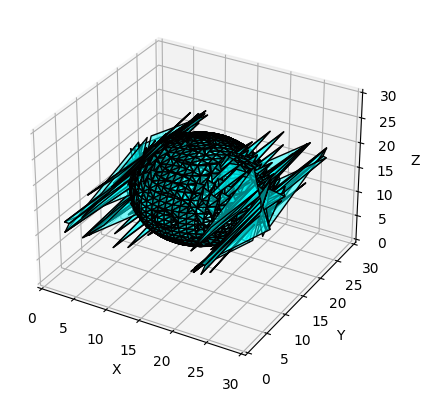

In [33]:
size = 30
radius = 8
threshold = radius
X, Y, Z = np.mgrid[:30, :30, :30]
u = (X-size//2)**2 + (Y-size//2)**2 + (Z-size//2)**2 - radius**2
# Call the marching_cubes function to extract the mesh
vertices, triangles = marching_cubes(u, 20)

# Plot the extracted mesh using Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_xlim(0, size)
ax.set_ylim(0, size)
ax.set_zlim(0, size)

poly3d_collection = Poly3DCollection(vertices[triangles], alpha=0.5, linewidths=1, edgecolors='k')
poly3d_collection.set_facecolor('cyan')
ax.add_collection3d(poly3d_collection)

plt.show()

## using pymcubes

In [3]:
def extract_mesh(model, N=256, near_bound=2, far_bound=6, num_ray_samples=128, batch_size=1024, threshold=50.0):
    # reference https://github.com/bmild/nerf/blob/master/extract_mesh.ipynb
    t = np.linspace(-1.2, 1.2, N+1)

    query_pts = np.stack(np.meshgrid(t, t, t), -1).astype(np.float32)
    sh = query_pts.shape
    flat = query_pts.reshape([-1, 3])

    # Calculate origins and directions for the dense 3D grid of points
    origins = torch.from_numpy(flat).float().to(DEVICE)
    directions = torch.zeros_like(origins).to(DEVICE)

    # Initialize an empty array for the density values (sigma)
    sigma = np.zeros(origins.shape[0])

    # Process the data in batches
    num_batches = int(np.ceil(origins.shape[0] / batch_size))

    for i in tqdm(range(num_batches)):
        start = i * batch_size
        end = min((i + 1) * batch_size, origins.shape[0])

        # Query the model
        _, batch_sigma = render_rays(
            model,
            origins[start:end],
            directions[start:end],
            near_bound=near_bound,
            far_bound=far_bound,
            num_ray_samples=num_ray_samples
        )

        # Convert the density values to a numpy array
        batch_sigma = batch_sigma.mean(axis=1).cpu().detach().numpy()

        # Store the density values in the appropriate locations
        sigma[start:end] = batch_sigma

    # Reshape the density values to match the shape of the 3D grid
    sigma = sigma.reshape(sh[:3])
    # Run marching cubes
    vertices, triangles = marching_cubes(sigma, threshold)

    return vertices, triangles


def plot_mesh(vertices, triangles, N=256):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    ax.set_xlim(0, N)
    ax.set_ylim(0, N)
    ax.set_zlim(0, N)

    poly3d_collection = Poly3DCollection(vertices[triangles], alpha=0.5, linewidths=1, edgecolors='k')
    poly3d_collection.set_facecolor('cyan')
    ax.add_collection3d(poly3d_collection)

    plt.show()

In [4]:
model = load_model("./lego.pth")

vertices, triangles = extract_mesh(model)
plot_mesh(vertices, triangles)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.